### ARIMA 모형 시계열 분석

ARIMA는 가장 널리 사용되고 있는 시계열 분석 모형이지만 최근에는 딥러닝을 이용하여 시계열 데이터의 연속성을 기계 스스로 찾아내도록 하는 방법이 더 좋은 성능을 내고 있다. 가장 대표적인 것이 LSTM이라는 RNN 종류의 네트워크 방식이다.

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [6]:
# 데이터 가져오기

df = pd.read_excel('http://itpaper.co.kr/data/coin.xlsx', engine='openpyxl')
df

,date,price
0,2020-06-30,9185.35
1,2020-07-01,9133.97
2,2020-07-02,9236.38
3,2020-07-03,9087.98
4,2020-07-04,9072.42
...,...,...
361,2021-06-26,31640.58
362,2021-06-27,32160.91
363,2021-06-28,34644.45
364,2021-06-29,34456.67


#### EDA

In [7]:
plt.rcParams["font.family"] = 'Malgun Gothic' # 한글 지원 폰트 설정
plt.rcParams["font.size"] = 14                # 기본 글자크기 설정
plt.rcParams["figure.figsize"] = (20, 10)     # 그래프 사이즈 (가로,세로)inch
plt.rcParams["axes.unicode_minus"] = False    # 유니코드 뺄셈기호 표시 사용 안함(깨짐방지)

In [8]:
# 그래프에 사용할 x축 좌표 리스트

min = df.index.min()
max = df.index.max()
x = list(range(min, max, 15))
x = x[1:-1]
print(x)

[15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345]


In [9]:
# 그래프의 x축 좌표위에 출력할 날짜값 추출하기

time = []

for i in x:
    time.append(df.loc[i, 'date'].strftime("%y/%m/%d"))

print(time)

['20/07/15', '20/07/30', '20/08/14', '20/08/29', '20/09/13', '20/09/28', '20/10/13', '20/10/28', '20/11/12', '20/11/27', '20/12/12', '20/12/27', '21/01/11', '21/01/26', '21/02/10', '21/02/25', '21/03/12', '21/03/27', '21/04/11', '21/04/26', '21/05/11', '21/05/26', '21/06/10']


In [13]:
# 그래프 제목에 표시할 데이터 날짜범위

min_date = df['date'].min().strftime("%y/%m/%d")
max_date = df['date'].max().strftime("%y/%m/%d")
print(min_date, "~", max_date)

20/06/30 ~ 21/06/30


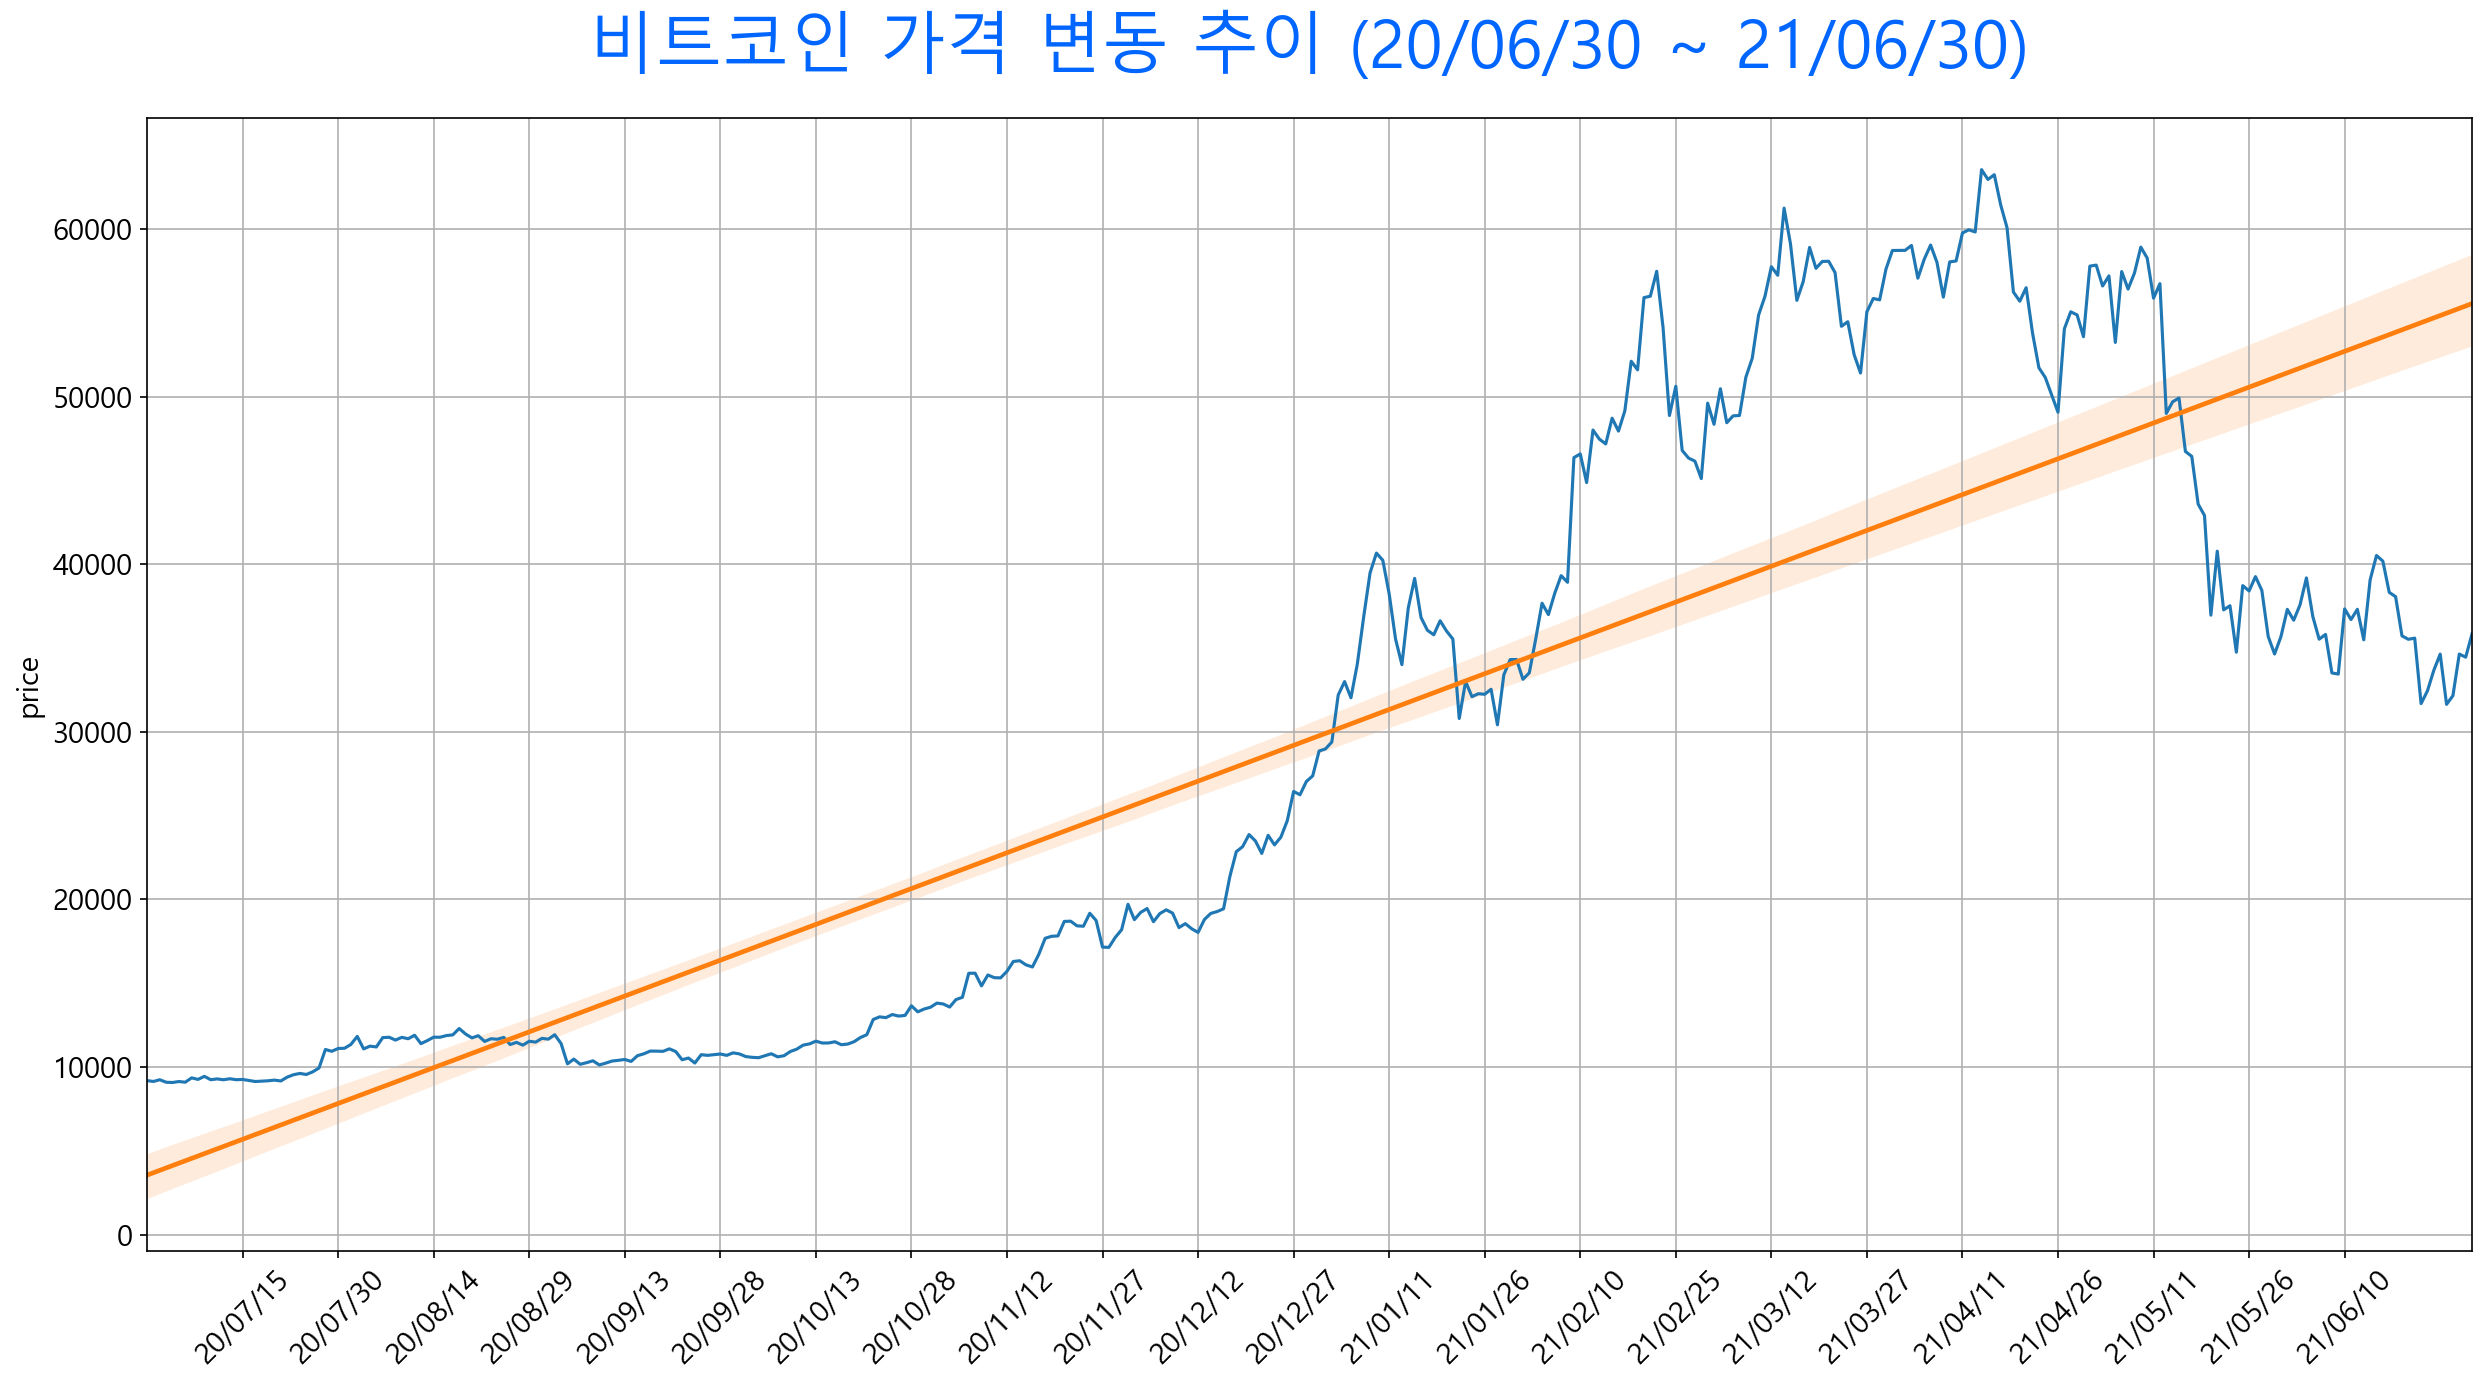

In [20]:
# 시계열 데이터와 추세선을 통해 데이터 경향 파악하기

fig, ax = plt.subplots(1, 1, figsize=(20,10), dpi= 150)

sns.lineplot(data=df, x=df.index, y='price', ax=ax)
sns.regplot(data=df, x=df.index, y='price', ax=ax, scatter=False)

ax.set_title('비트코인 가격 변동 추이 (%s ~ %s)' % (min_date, max_date), fontsize=32, color="#0066ff", pad=24)
plt.xticks(x)
ax.set_xticklabels(time, rotation=45, fontsize=14)
ax.grid()

plt.show()
plt.close()

#### ARIMA 모델을 적용하기 위한 시계열 정상성 검정

In [21]:
# 데이터의 정상성 검정을 위한 함수 정의

def my_adf_test(dataset):
    result = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",result[0])
    print("2. P-Value : ", result[1])
    print("3. Num Of Lags : ", result[2])
    print("4. Num Of Observations Used For ADF Regression:",result[3])
    print("5. Critical Values :")
    
    cv = {}
    for key, val in result[4].items():
        print("\t",key, ": ", val)
        cv[key] = val
        
    #if result[0] < cv['1%'] and result[1] < 0.01:
    if result[0] < cv['5%'] and result[1] < 0.05:
    #if result[0] < cv['10%'] and result[1] < 0.1:
        print("[O] 시계열이 안정적임")
    else:
        print("[X] 시계열이 안정적이지 않음")


In [24]:
# ADF 검정 수행

my_adf_test(df['price'])

# (2)p-value가 0.05보다 크고,  (1)ADF 검정 통계량`이 5% 유의수준에 대한 
# (5)Critical Values보다 크기 때문에 시계열 데이터가 정상성을 충족하지 않는다고 볼 수 있다.

1. ADF :  -1.2073123468017088
2. P-Value :  0.6704422411924651
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 353
5. Critical Values :
	 1% :  -3.4490114443793214
	 5% :  -2.8697627072503757
	 10% :  -2.5711506161673716
[X] 시계열이 안정적이지 않음


In [25]:
# 데이터 정상화를 위한 1차 차분 수행

coin_ff = np.diff(df['price'], 1)
coin_ff
my_adf_test(coin_ff)

1. ADF :  -5.410640365247549
2. P-Value :  3.217191702997045e-06
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 353
5. Critical Values :
	 1% :  -3.4490114443793214
	 5% :  -2.8697627072503757
	 10% :  -2.5711506161673716
[O] 시계열이 안정적임


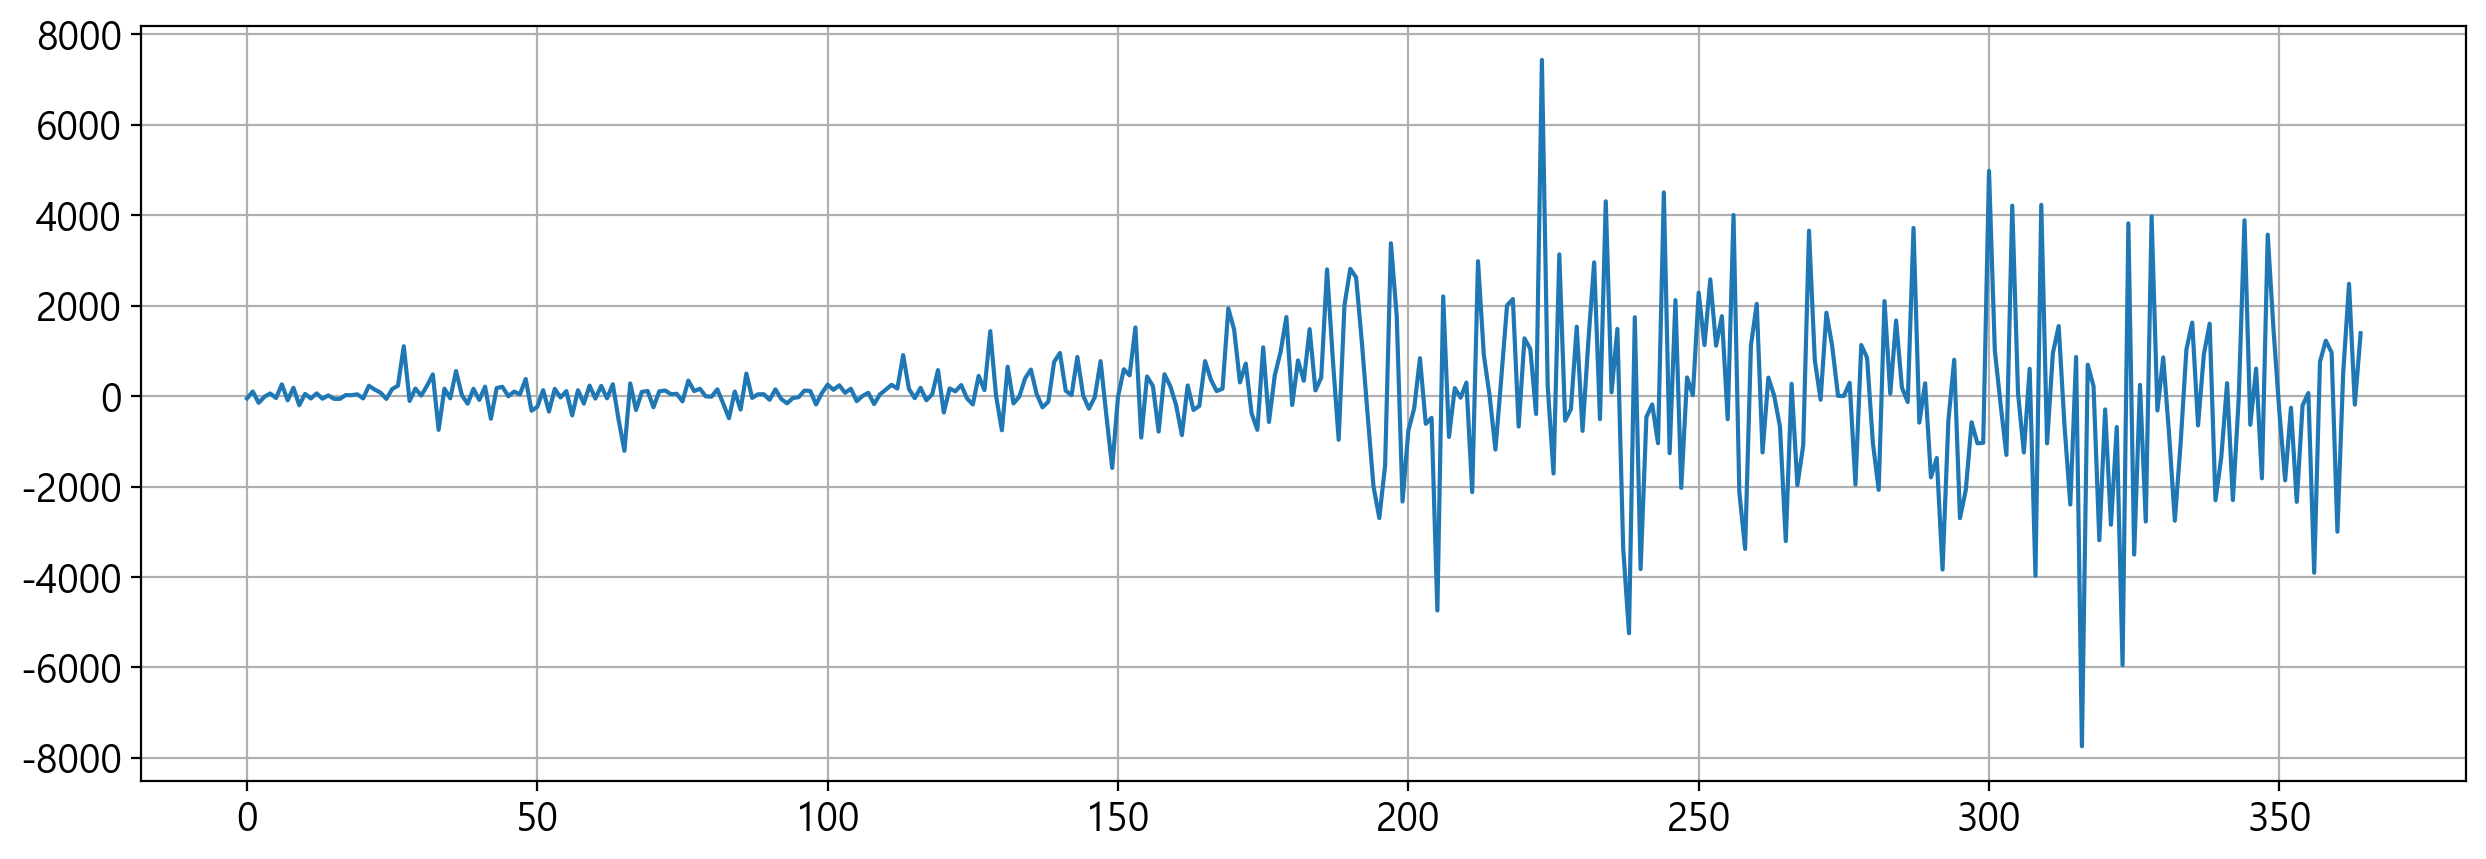

In [26]:
# 잔차 결과에 대한 시각화

fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
ax.plot(coin_ff)
ax.grid()
plt.show()
plt.close()

#### ARIMA 모델을 통한 시계열 분석

In [28]:
# p, d, q 값 자동으로 찾기
# 최적의 차수 횟수 `d`와 AR(자기회귀)의 모수 `p`, MA(이동평균)의 모수 `q` 를 직접 찾는 것은 매우 어려운 작업이다.
# `auto_arima` 함수를 통해 p, d, q 값을 자동으로 검출할 수 있다.

aa_model = auto_arima(df['price'], start_p=0, start_q=0, max_p=3, max_q=3,
                trace=True,suppress_warnings=True,stepwise=False,seasonal=False)
aa_model.fit(df['price'])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6402.616, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6401.203, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6400.283, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6401.372, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6400.632, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6401.848, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6401.396, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6403.250, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6400.816, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6401.845, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6403.278, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6405.030, Time=0.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6401.218, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6403.075, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6405.113, Time=0.35 sec

Best mode

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [29]:
# 시계열 분석 수행하기

# 시계열 분석 모델 적제
model = ARIMA(df['price'], order=aa_model.order)

# 분석 수행 및 분석 결과 리턴받기
# -> 이 객체를 통해 시계열 분석의 예측데이터를 얻을 수 있다.
fit = model.fit()

# 분석 결과 확인
print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3195.971
Method:                       css-mle   S.D. of innovations           1536.266
Date:                Fri, 06 Aug 2021   AIC                           6399.943
Time:                        11:14:54   BIC                           6415.542
Sample:                             1   HQIC                          6406.142
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            73.0475     79.093      0.924      0.356     -81.971     228.066
ma.L1.D.price    -0.1089      0.053     -2.066      0.039      -0.212      -0.006
ma.L2.D.price     0.0927      0.052     

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


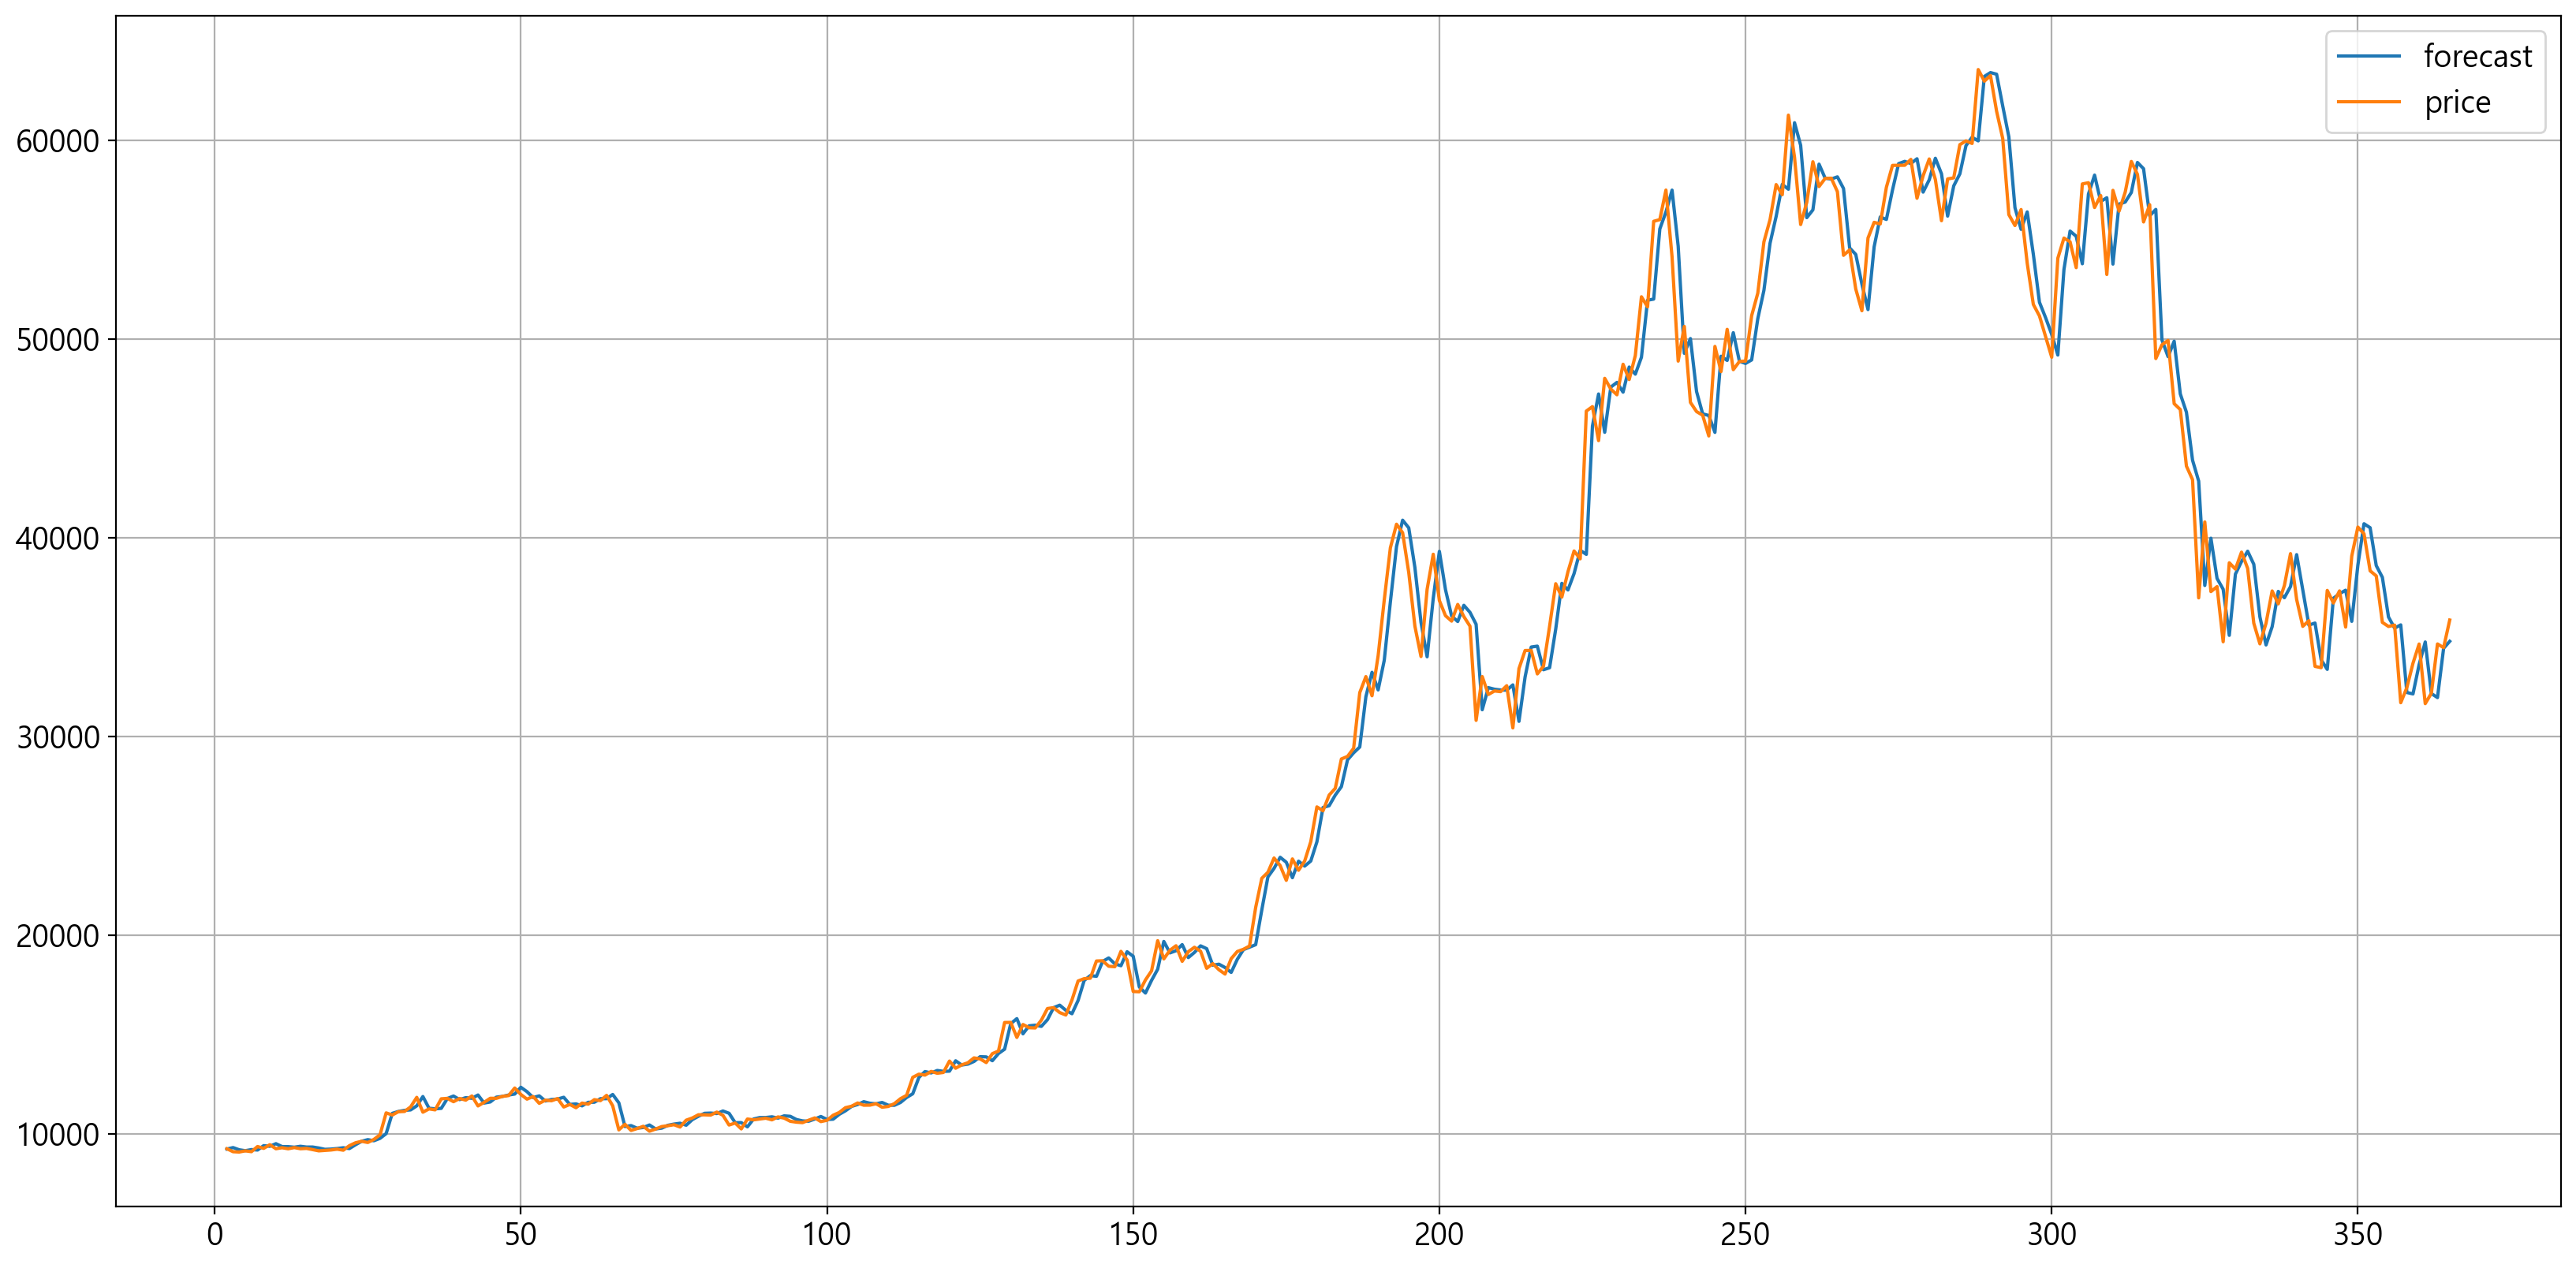

In [30]:
# 분석결과 시각화

fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=200)
fit.plot_predict(ax=ax)
ax.grid()
plt.show()
plt.close()

#### 시계열 분석 결과를 활용하여 미래 예측하기

In [31]:
# 유의수준 5% 이하에서 학습 데이터로부터 15일 후를 예측

fc, se, conf = fit.forecast(15, alpha=0.05) # 유의수준 5%
print(fc)
print(conf)

[35807.04855424 35979.40461634 36052.45215054 36125.49968473
 36198.54721893 36271.59475312 36344.64228732 36417.68982151
 36490.73735571 36563.7848899  36636.8324241  36709.87995829
 36782.92749248 36855.97502668 36929.02256087]
[[32796.02234569 38818.07476279]
 [31946.37389773 40012.43533496]
 [31048.42529817 41056.47900291]
 [30310.41303868 41940.58633079]
 [29672.43193776 42724.66250009]
 [29104.64780027 43438.54170597]
 [28589.63896127 44099.64561336]
 [28116.18245545 44719.19718758]
 [27676.54581531 45304.9288961 ]
 [27265.13334934 45862.43643046]
 [26877.74084575 46395.92400245]
 [26511.11452337 46908.64539321]
 [26162.67493624 47403.18004873]
 [25830.33616445 47881.61388891]
 [25512.38293784 48345.66218391]]


In [32]:
# 예측값에 대한 데이터프레임에서 사용할 인덱스값 생성

# 원본 데이터프레임의 인덱스 최대값 다음 데이터부터...
s = df.index.max()+1
# s로부터 15개 
e = s + 15
# s~e 사이의 수열을 리스트로 변환
idx = list(range(s, e))
print(idx)

[366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]


In [33]:
# 예측 데이터 프레임

fc_df = pd.DataFrame(fc, index=idx).rename(columns={0:'예측'})
fc_df

,예측
366,35807.048554
367,35979.404616
368,36052.452151
369,36125.499685
370,36198.547219
371,36271.594753
372,36344.642287
373,36417.689822
374,36490.737356
375,36563.784890


In [34]:
# 최소, 최대값 범위 데이터 프레임

conf_df = pd.DataFrame(conf, index=idx).rename(columns={0:'최소', 1:'최대'})
conf_df

,최소,최대
366,32796.022346,38818.074763
367,31946.373898,40012.435335
368,31048.425298,41056.479003
369,30310.413039,41940.586331
370,29672.431938,42724.662500
371,29104.647800,43438.541706
372,28589.638961,44099.645613
373,28116.182455,44719.197188
374,27676.545815,45304.928896
375,27265.133349,45862.436430


In [36]:
# 예측값과 최소, 최대값 데이터프레임 병합

예측df = pd.merge(fc_df, conf_df, left_index=True, right_index=True)
예측df


,예측,최소,최대
366,35807.048554,32796.022346,38818.074763
367,35979.404616,31946.373898,40012.435335
368,36052.452151,31048.425298,41056.479003
369,36125.499685,30310.413039,41940.586331
370,36198.547219,29672.431938,42724.662500
371,36271.594753,29104.647800,43438.541706
372,36344.642287,28589.638961,44099.645613
373,36417.689822,28116.182455,44719.197188
374,36490.737356,27676.545815,45304.928896
375,36563.784890,27265.133349,45862.436430


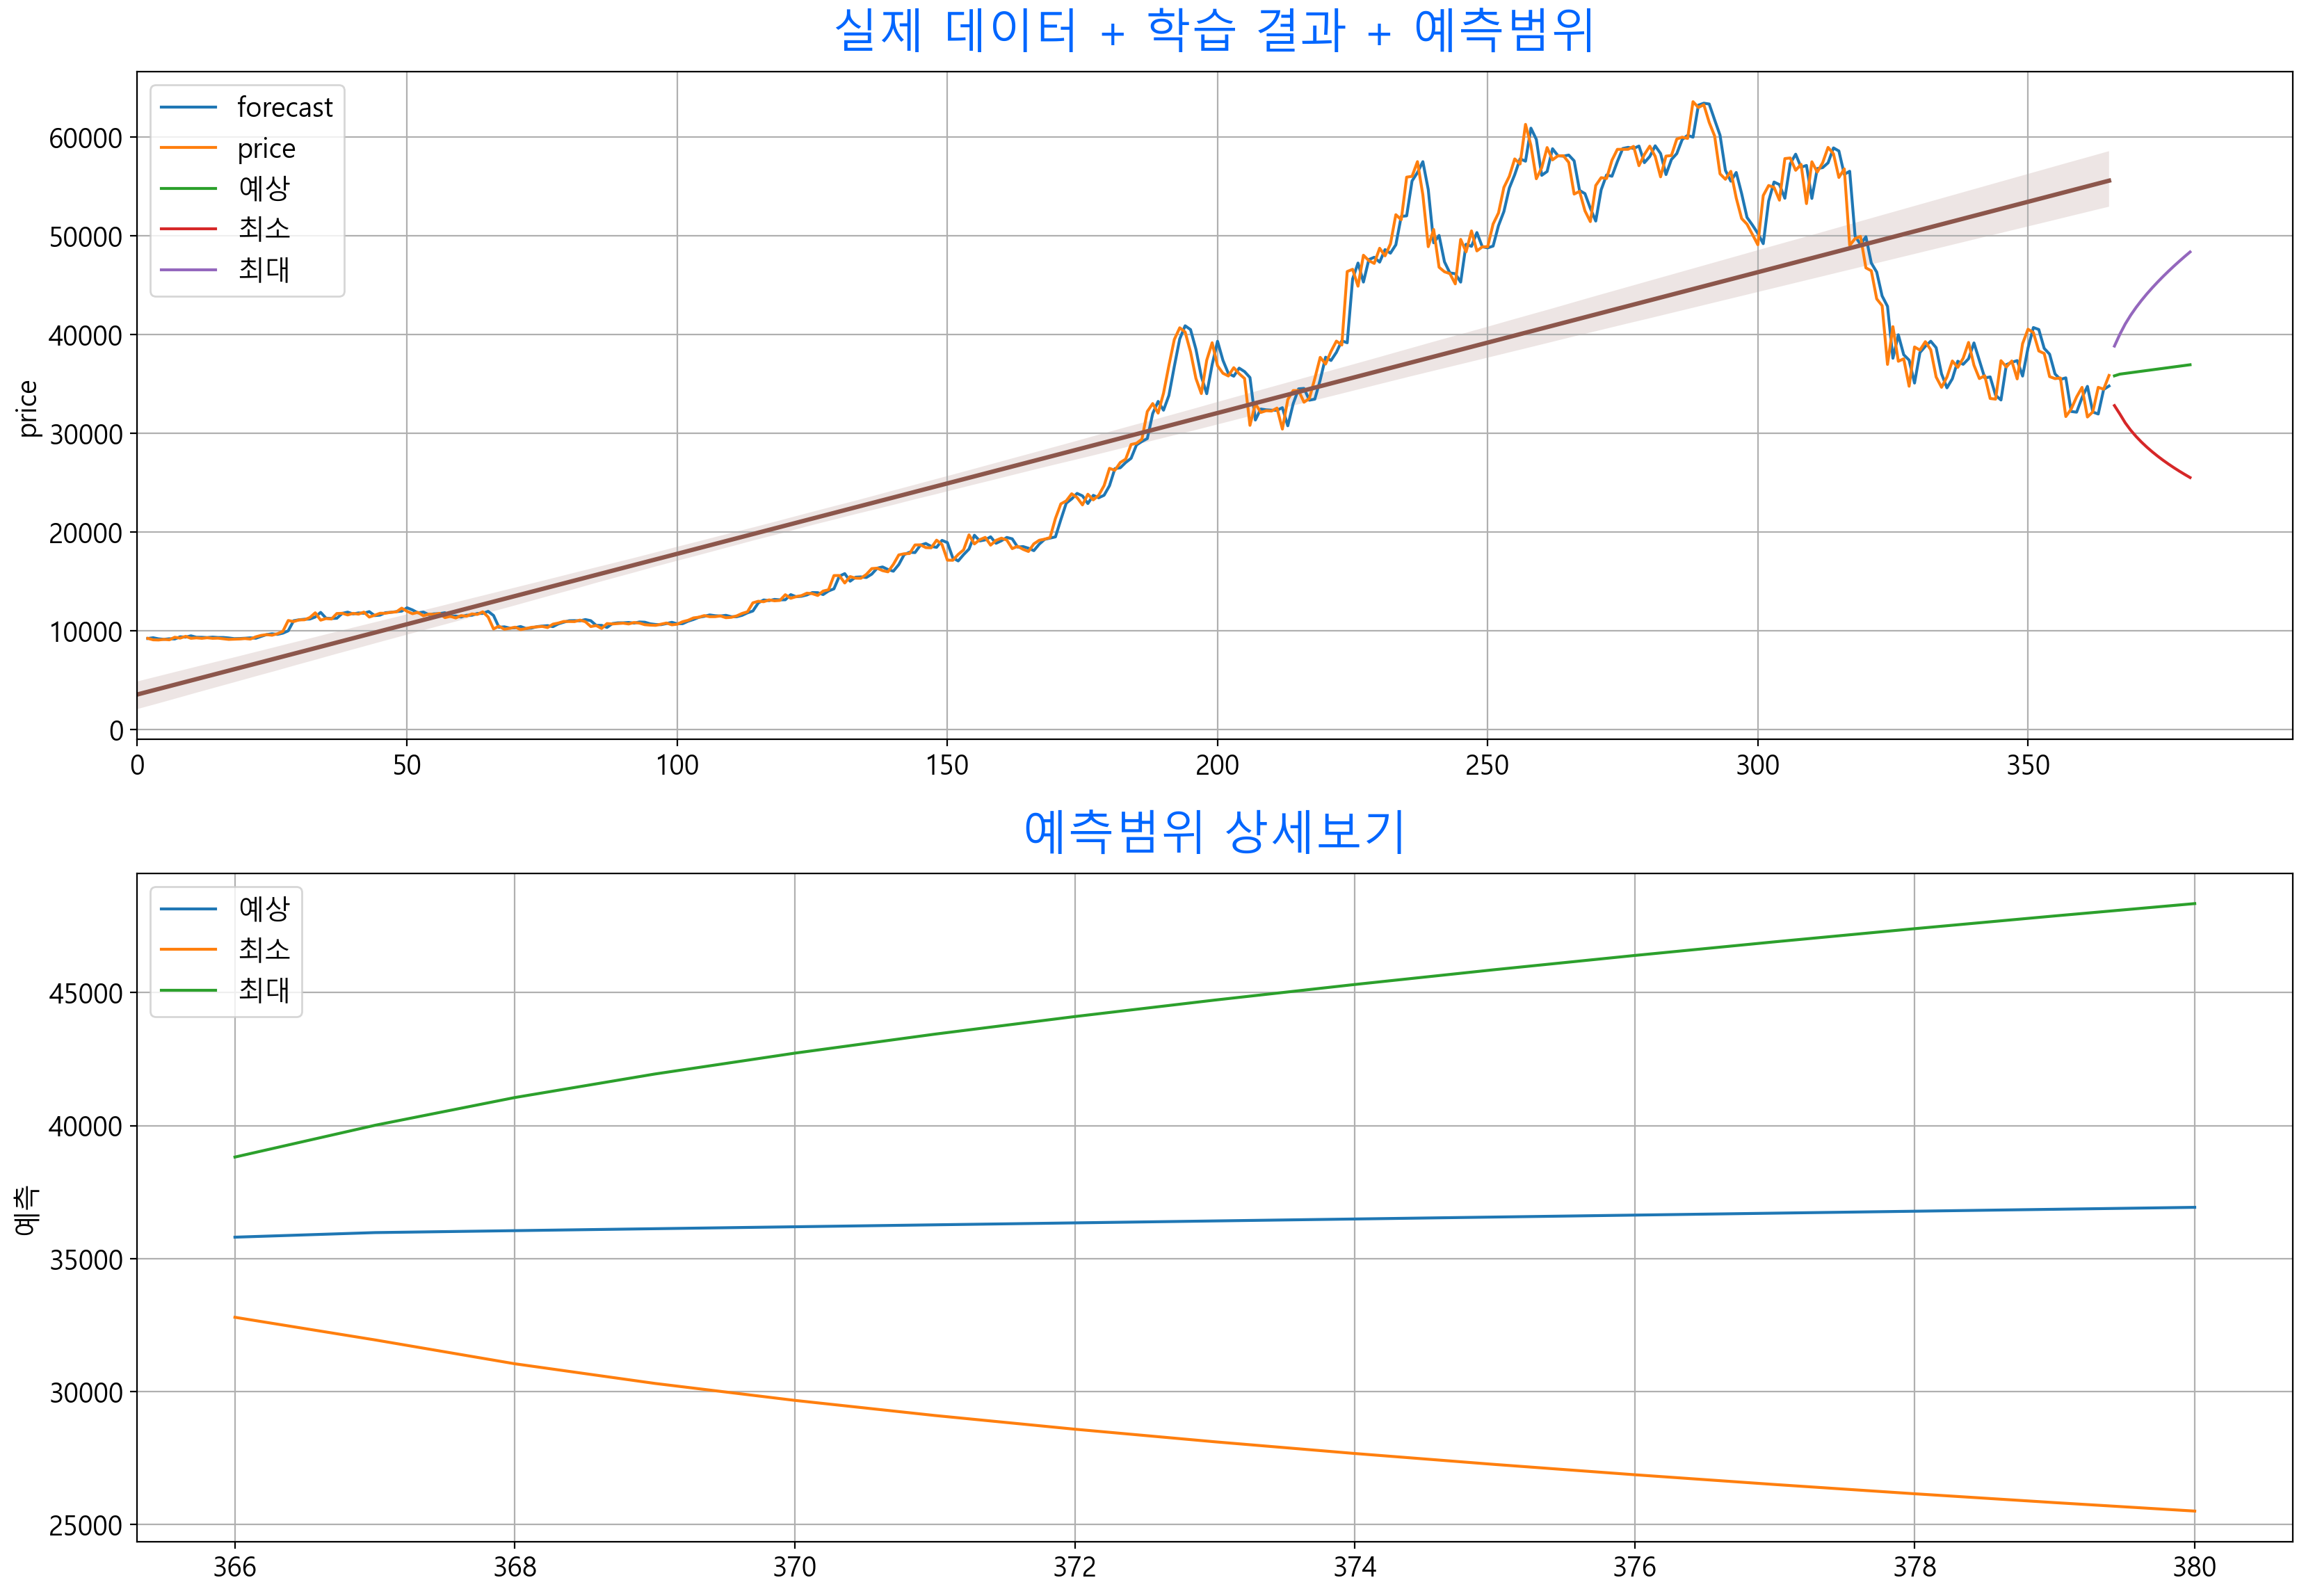

In [37]:
# 분석결과와 예측범위 시각화 하기

fig, ax = plt.subplots(2, 1, figsize=(20, 14), dpi=200)

# 1행 1열에 대한 그래프 처리
#---------------------------------------
# 실 데이터와 분석 결과 표시
fit.plot_predict(ax=ax[0])
# 분석결과 이후 예측 범위 데이터를 추가로 시각화 함
sns.lineplot(x=fc_df.index, y='예측', label='예상', data=예측df, ax=ax[0])
sns.lineplot(x=fc_df.index, y='최소', label='최소', data=예측df, ax=ax[0])
sns.lineplot(x=fc_df.index, y='최대', label='최대', data=예측df, ax=ax[0])
# 실 데이터에 대한 추세선 표시
sns.regplot(x=df.index, y='price', data=df, ax=ax[0], scatter=False)
# 그래프 제목
ax[0].set_title('실제 데이터 + 학습 결과 + 예측범위', fontsize=24, pad=12, color='#0066ff')
# 배경 격자
ax[0].grid()
# 범주 위치 지정
ax[0].legend(loc='upper left')

# 2행 1열에 대한 그래프 처리
#---------------------------------------
# 실 데이터에 대한 분석 결과 이후 예측 범위 데이터만 확대 표시
sns.lineplot(x=fc_df.index, y='예측', label='예상', data=예측df, ax=ax[1])
sns.lineplot(x=fc_df.index, y='최소', label='최소', data=예측df, ax=ax[1])
sns.lineplot(x=fc_df.index, y='최대', label='최대', data=예측df, ax=ax[1])
ax[1].set_title('예측범위 상세보기', fontsize=24, pad=12, color='#0066ff')
ax[1].grid()

# 그래프 화면 표시 및 종료
#---------------------------------------
plt.show()
plt.close()